In [11]:
import scipy
import random
import datetime
import json
import numpy as np

# Step1 定义PATH & 更改文件夹名称

In [56]:
""""
    dict structure（original）:
        ├─annotations
        ├─train(2975)
        ├─test(1525)
        └─val(500)
"""
# 根目录
ROOT = '/home/wong/Documents/DataSet/CityPerson/'
# 标注存放位置
ANNO_DIR = ROOT + 'annotations/'
# COCO format标注save位置
COCO_ANNO_DIR = ROOT + 'annotations/'

# 原始文件路径
SOURCE_TRAIN_DIR = ROOT + 'train_source/'
SOURCE_VAL_DIR = ROOT + 'val_source/'
SOURCE_TEST_DIR = ROOT + 'test_source/' # never used

# 从train分割test和val的目标路径
TARGET_TRAIN_DIR = ROOT + 'train/'
TARGET_VAL_DIR = ROOT + 'val/'
TARGET_TEST_DIR = ROOT + 'test/'

# 从训练集中分割val集的比例
VAL_SET_PAR = 0.2

# debug数据集
DEBUG_SIZE_TRAIN = 40
DEBUG_SIZE_VAL = 20

anno_train_file_mat = 'anno_train.mat'
anno_val_file_mat = 'anno_val.mat'

# 定义label 标签
city_person_label_list = [
    {'id': 0, 'name': 'ignore regions'},
    {'id': 1, 'name': 'pedestrians'},
    {'id': 2, 'name': 'riders'},
    {'id': 3, 'name': 'sitting persons'},
    {'id': 4, 'name': 'unusual postures'},
    {'id': 5, 'name': 'group of people'}]

In [5]:
import os
# 给原始文件夹改名（加后缀）
if os.path.exists(TARGET_TRAIN_DIR):
    os.rename(TARGET_TRAIN_DIR, SOURCE_TRAIN_DIR)
if os.path.exists(TARGET_VAL_DIR):
    os.rename(TARGET_VAL_DIR, SOURCE_VAL_DIR)
if os.path.exists(TARGET_TEST_DIR):
    os.rename(TARGET_TEST_DIR, SOURCE_TEST_DIR)

In [7]:
# 创建新文件夹
if not os.path.exists(TARGET_TRAIN_DIR):
    os.mkdir(TARGET_TRAIN_DIR)
if not os.path.exists(TARGET_VAL_DIR):
    os.mkdir(TARGET_VAL_DIR)
if not os.path.exists(TARGET_TEST_DIR):
    os.mkdir(TARGET_TEST_DIR)

# Step2 读取annotation（对应train_source & val_source）

In [21]:
anno_train_mat = scipy.io.loadmat(ANNO_DIR + anno_train_file_mat)
anno_val_mat = scipy.io.loadmat(ANNO_DIR + anno_val_file_mat)
anno_train_mat.keys()
anno_train_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'anno_val_aligned'])

In [22]:
# 看一下不重要的几个element
print(anno_train_mat["__header__"])
print(anno_train_mat["__version__"])
print(anno_train_mat["__globals__"])

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 23 10:53:38 2017'
1.0
[]


In [23]:
# flatten
anno_train_mat = anno_train_mat["anno_train_aligned"].flatten()
anno_val_mat = anno_val_mat["anno_val_aligned"].flatten()
print(f'train_source_set_size={anno_train_mat.shape}, test_source_set_size={anno_val_mat.shape}')
anno_train_mat[1]

train_source_set_size=(2975,), test_source_set_size=(500,)


array([[(array(['aachen'], dtype='<U6'), array(['aachen_000001_000019_leftImg8bit.png'], dtype='<U36'), array([[  0, 877, 383,  14,  26,   0, 877, 383,  14,  26],
               [  0, 878, 423,  15,  25,   0, 878, 423,  15,  25],
               [  0, 464, 439,  11,  10,   0, 464, 439,  11,  10],
               [  0,  65, 425,  32,  25,   0,  65, 425,  32,  25]], dtype=uint16))                                                                                ]],
      dtype=[('cityname', 'O'), ('im_name', 'O'), ('bbs', 'O')])

In [35]:
# 读取mat格式到list
def unzip_annotation(data):
    datasets = []

    for cell in data:
        city_name, im_name, bbs = cell[0][0]
        bbs_new = []
        for each in bbs:
            class_label, x1, y1, w, h, instance_id, x1_vis, y1_vis, w_vis, h_vis = each
            bbs_new.append(
                {
                    "class_label": class_label,
                    "x1": x1,
                    "y1": y1,
                    "w": w,
                    "h": h,
                    "instance_id": instance_id,
                    "x1_vis": x1_vis,
                    "y1_vis": y1_vis,
                    "w_vis": w_vis,
                    "h_vis": h_vis,
                }
            )
        # mistake in dataset
        if city_name[0] == 'tuebingen':
            city_name[0] = 'tubingen'
        datasets.append({"city_name": city_name[0], "im_name": im_name[0], "bbs": bbs_new})
        
    return datasets

In [36]:
train_source = unzip_annotation(anno_train_mat)
val_source = unzip_annotation(anno_val_mat)

In [37]:
print(len(train_source), len(val_source), type(train_source), type(val_source))
print(train_source[0])

2975 500 <class 'list'> <class 'list'>
{'city_name': 'aachen', 'im_name': 'aachen_000000_000019_leftImg8bit.png', 'bbs': [{'class_label': 3, 'x1': 892, 'y1': 445, 'w': 21, 'h': 53, 'instance_id': 24000, 'x1_vis': 892, 'y1_vis': 445, 'w_vis': 21, 'h_vis': 53}, {'class_label': 3, 'x1': 901, 'y1': 443, 'w': 34, 'h': 55, 'instance_id': 24001, 'x1_vis': 901, 'y1_vis': 443, 'w_vis': 34, 'h_vis': 55}, {'class_label': 2, 'x1': 1844, 'y1': 436, 'w': 44, 'h': 106, 'instance_id': 25000, 'x1_vis': 1844, 'y1_vis': 441, 'w_vis': 44, 'h_vis': 101}, {'class_label': 0, 'x1': 1025, 'y1': 215, 'w': 28, 'h': 34, 'instance_id': 0, 'x1_vis': 1025, 'y1_vis': 215, 'w_vis': 28, 'h_vis': 34}]}


372
1 1339 413 38 92
1 1305 413 40 97
1 1275 417 34 83
1 1282 412 48 115
1 1432 416 39 98
1 1449 411 43 106
1 1543 398 93 228
1 1017 424 21 53
4 779 436 43 56
1 743 408 33 79
1 706 395 47 115
3 525 424 23 29
3 509 420 24 45
3 551 427 62 84
3 348 411 62 125
3 324 410 64 126
1 -6 322 126 307
1 192 337 110 267
1 227 287 133 326
1 1310 393 68 166
2 1114 388 54 130
2 1176 335 109 268
2 959 422 17 42
2 624 359 83 203
0 1869 383 29 135
0 982 436 6 14
0 1039 430 9 20
0 456 424 54 83
0 813 414 14 26


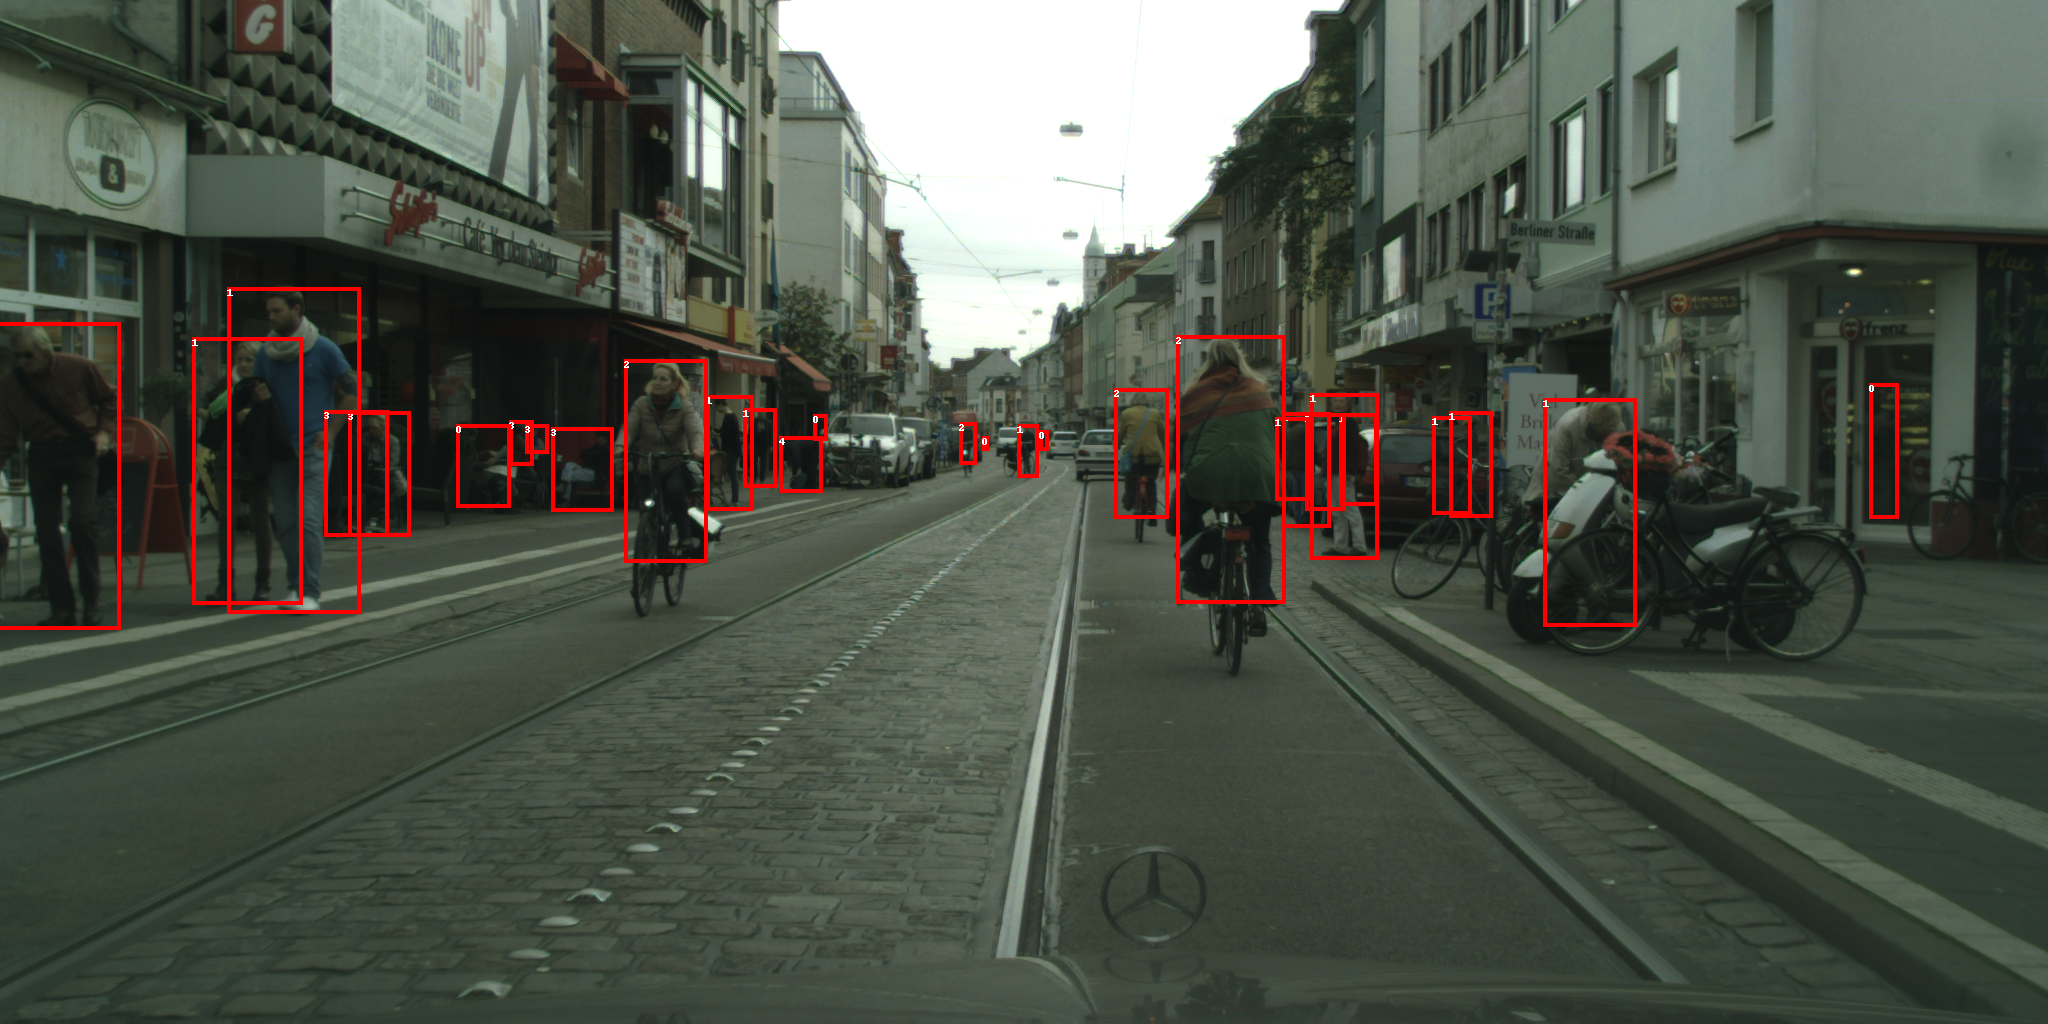

In [38]:
from PIL import Image, ImageDraw

rand_index = random.randint(0, len(train_source))
print(rand_index)

city_name = train_source[rand_index]['city_name']
im_name = train_source[rand_index]['im_name']
im_path = SOURCE_TRAIN_DIR + im_name

image = Image.open(im_path)

draw = ImageDraw.Draw(image, "RGBA")

for box in train_source[rand_index]['bbs']:
    class_idx = box['class_label']
    x, y, w, h = box['x1'], box['y1'], box['w'], box['h']
    print(class_idx, x, y, w, h)
    draw.rectangle((x, y, x + w, y + h), outline='red', width=4)
    text = str(class_idx)
    draw.text(xy=(x, y), text=text, fill='white')

image

# 随机分割train_source为train和val

In [42]:
# 按比例分割
random.seed(int(42))
random.shuffle(train_source)

split_index = int(VAL_SET_PAR * len(train_source))
val_split = train_source[:split_index]
train_split = train_source[split_index:]
test_split = val_source

print(len(train_split), len(val_split), len(test_split))

2380 595 500


In [48]:
import shutil
# 按照分割移动图片
for item in train_split:
    source_path = SOURCE_TRAIN_DIR + item['im_name']
    target_path = TARGET_TRAIN_DIR + item['im_name']
    if os.path.isfile(source_path):
        shutil.copy(source_path, target_path)
    else:
        print("ERROR:", source_path, target_path)
        
for item in val_split:
    source_path = SOURCE_TRAIN_DIR + item['im_name']
    target_path = TARGET_VAL_DIR + item['im_name']
    if os.path.isfile(source_path):
        shutil.copy(source_path, target_path)
    else:
        print("ERROR:", source_path, target_path)
        
for item in test_split:
    source_path = SOURCE_VAL_DIR + item['im_name']
    target_path = TARGET_TEST_DIR + item['im_name']
    if os.path.isfile(source_path):
        shutil.copy(source_path, target_path)
    else:
        print("ERROR:", source_path, target_path)

In [50]:
# check for every image
train_count = 0
val_count = 0
test_count=0
for item in train_split:
    target_path = TARGET_TRAIN_DIR + item['im_name']
    if not os.path.isfile(target_path):
        print("ERROR:", target_path)
    train_count += 1
for item in val_split:
    target_path = TARGET_VAL_DIR + item['im_name']
    if not os.path.isfile(target_path):
        print("ERROR:", target_path)
    val_count += 1
for item in test_split:
    target_path = TARGET_TEST_DIR + item['im_name']
    if not os.path.isfile(target_path):
        print("ERROR:", target_path)
    test_count += 1
    
print(train_count, val_count, test_count)   

2380 595 500


# 转为JSON格式并保存JSON文件

In [52]:
# 拼接图片信息到dict
def create_image_info(
        image_id,
        file_name,
        image_size,
        date_captured=datetime.datetime.utcnow().isoformat(" "),
        license_id=1,
        coco_url="",
        flickr_url="",
):
    image_info = {
        "id": image_id,
        "file_name": file_name,
        "width": image_size[0],
        "height": image_size[1],
        "date_captured": date_captured,
        "license": license_id,
        "coco_url": coco_url,
        "flickr_url": flickr_url,
    }

    return image_info

In [53]:
def convert2json(
        imgdir,
        anno_array,
        category_dict_list=None,
        super_categories=['CityPerson'],
        output_file_name=None,
        max_size=None
):
    if category_dict_list is None:
        print("Need categories!")
        return

    coco_output = {}

    coco_output["info"] = {
        "description": "City Person",
        "url": "https://github.com/CharlesShang/Detectron-PYTORCH",
        "version": "0.1.0",
        "year": 2015,
        "contributor": "CharlesShang",
        "date_created": datetime.datetime.utcnow().isoformat(" "),
    }

    coco_output["licenses"] = [
        {
            "id": 1,
            "name": "-",
            "url": "-",
        }
    ]

    coco_output["categories"] = [
        {
            "id": cat_dict["id"],
            "name": cat_dict["name"],
            "supercategory": super_categories[0],
        }
        for cat_dict in category_dict_list
    ]

    coco_output["images"] = []
    coco_output["annotations"] = []
    box_id = 0
    img_id = 0
    
    if max_size is None or max_size > len(anno_array):
        max_size = len(anno_array)
    
    for i in range(max_size):
        ann_item = anno_array[i]
        filename = ann_item['im_name']
        img = Image.open(imgdir + filename)
        # make image info and storage it in coco_output['images']
        image_info = create_image_info(
            img_id, filename, image_size=img.size
        )
        is_crowd = 0
        coco_output["images"].append(image_info)
        bboxes = ann_item["bbs"]
        for box in bboxes:
            x, y, w, h = int(box['x1']), int(box['y1']), int(box['w']), int(box['h'])
            annotation_info = {
                "id": int(box_id),
                "image_id": int(img_id),
                "category_id": int(box['class_label']),
                "iscrowd": is_crowd,
                "area": int(w * h),  # float
                "bbox": [x, y, w, h],  # [x,y,width,height]
                "segmentation": None,  # [polygon]
            }
            coco_output["annotations"].append(annotation_info)
            box_id += 1
        img_id += 1
    
    if output_file_name is not None:
        print("Saving to {}".format(output_file_name))
        with open(output_file_name, "w") as out_f:
            json.dump(coco_output, out_f)
            
    return coco_output

In [54]:
# test
json_train = convert2json(imgdir=TARGET_TRAIN_DIR, anno_array=train_split, category_dict_list=city_person_label_list,
                    output_file_name=COCO_ANNO_DIR + 'custom_train.json')
# val
json_val = convert2json(imgdir=TARGET_VAL_DIR, anno_array=val_split, category_dict_list=city_person_label_list, output_file_name=COCO_ANNO_DIR+'custom_val.json')
# # train
json_test = convert2json(imgdir=TARGET_TEST_DIR, anno_array=test_split, category_dict_list=city_person_label_list, output_file_name=COCO_ANNO_DIR+'custom_test.json')

Saving to /home/wong/Documents/DataSet/CityPerson/annotations/custom_train.json
Saving to /home/wong/Documents/DataSet/CityPerson/annotations/custom_val.json
Saving to /home/wong/Documents/DataSet/CityPerson/annotations/custom_test.json


In [57]:
# test
json_train_debug = convert2json(imgdir=TARGET_TRAIN_DIR, anno_array=train_split, category_dict_list=city_person_label_list,
                          output_file_name=COCO_ANNO_DIR + 'custom_train_debug.json', max_size=DEBUG_SIZE_TRAIN)
# val
json_val_debug = convert2json(imgdir=TARGET_VAL_DIR, anno_array=val_split, category_dict_list=city_person_label_list,
                        output_file_name=COCO_ANNO_DIR + 'custom_val_debug.json', max_size=DEBUG_SIZE_VAL)

Saving to /home/wong/Documents/DataSet/CityPerson/annotations/custom_train_debug.json
Saving to /home/wong/Documents/DataSet/CityPerson/annotations/custom_val_debug.json


In [63]:
import json 
import os

def check(json_file_path, folder_path):
    with open(json_file_path, 'r') as anno_file:
        anno_data = json.load(anno_file)
    image_list = anno_data['images']
    count = 0
    for im in image_list:
        im_path = folder_path + im['file_name']
        if not os.path.isfile(im_path):
            print("ERROR: NOT FOUND " + im_path)
            return False
        else:
            count += 1
    print(f"CHECKED {count} images in {folder_path} with {json_file_path} \n")
    return True

In [66]:
check(COCO_ANNO_DIR + 'custom_train_debug.json', TARGET_TRAIN_DIR)
check(COCO_ANNO_DIR + 'custom_val_debug.json', TARGET_VAL_DIR)

check(COCO_ANNO_DIR + 'custom_train.json', TARGET_TRAIN_DIR)
check(COCO_ANNO_DIR + 'custom_val.json', TARGET_VAL_DIR)
check(COCO_ANNO_DIR + 'custom_test.json', TARGET_TEST_DIR)

CHECKED 40 images in /home/wong/Documents/DataSet/CityPerson/train/ with /home/wong/Documents/DataSet/CityPerson/annotations/custom_train_debug.json
CHECKED 20 images in /home/wong/Documents/DataSet/CityPerson/val/ with /home/wong/Documents/DataSet/CityPerson/annotations/custom_val_debug.json
CHECKED 2380 images in /home/wong/Documents/DataSet/CityPerson/train/ with /home/wong/Documents/DataSet/CityPerson/annotations/custom_train.json
CHECKED 595 images in /home/wong/Documents/DataSet/CityPerson/val/ with /home/wong/Documents/DataSet/CityPerson/annotations/custom_val.json
CHECKED 500 images in /home/wong/Documents/DataSet/CityPerson/test/ with /home/wong/Documents/DataSet/CityPerson/annotations/custom_test.json


True